In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

# Prepare data

In [2]:
#  Load the climate data

file_path = "Kalam Climate Data.xlsx"   
climate_df = pd.read_excel(file_path)

climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

# Extract date

climate_df['date'] = climate_df['Date Time'].dt.date

# Daily aggregation
daily_climate = climate_df.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

daily_climate["date"] = pd.to_datetime(daily_climate["date"])

# Filter DataFrame
extra_month_df = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]


new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}


extra_month_df.rename(columns=new_names, inplace=True)

all_data_df = pd.read_csv("Data.csv")

all_data_df.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow", "current", "power_factor"], inplace=True)
all_data_df.head()

# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])


# Extract date (drop time)
all_data_df['date'] = all_data_df['date_time'].dt.date


# Group by Source (consumer_device + data_user) and date

daily_df = all_data_df.groupby(['Source', 'date']).agg({
    'kwh': 'sum'  
})

daily_df = daily_df.reset_index()


# Ensure datetime index
daily_df = daily_df.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily_df = daily_df.join(daily_climate, how="left")


merged_daily_df.reset_index(inplace=True)

merged_daily_df.to_csv("second_daily_merged_hydro_climate.csv", index=False)


# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily_df.rename(columns=new_names, inplace=True)

# Feature engineering

In [3]:
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Reindex all Sources across full date range ---

def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    # fill missing kwh with 0
    df_full["kwh"] = df_full["kwh"].fillna(0)
    # climate features same across sources, fill forward
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)

# Drop rows without lag features
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]



In [4]:
# --- Train/test split ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Let us train a LightGBM model

In [9]:
# Regression
reg = LGBMRegressor(n_estimators=300, random_state=42)
reg.fit(train_df[feature_cols], train_df["kwh"])
test_df["pred_kwh"] = np.maximum(0, reg.predict(test_df[feature_cols]))

# --- Global Metrics ---
print("=== Global Metrics ===")
rmse = mean_squared_error(test_df["kwh"], test_df["pred_kwh"], squared=False)
mape = mean_absolute_percentage_error(test_df["kwh"], test_df["pred_kwh"])
print(f"Regression: RMSE={rmse:.3f} \n")

# --- Per Source Metrics ---
print("=== Per Source Metrics ===")
sources = df["Source"].unique()
per_source_results = []
for src in sources:
    t_src = test_df[test_df["Source"]==src]
    if len(t_src)==0:
        continue
    rmse = mean_squared_error(t_src["kwh"], t_src["pred_kwh"], squared=False)
    mape = mean_absolute_percentage_error(t_src["kwh"], t_src["pred_kwh"])
    per_source_results.append((src, rmse))

per_source_df = pd.DataFrame(per_source_results, columns=["Source","RMSE"])
print(per_source_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4654
[LightGBM] [Info] Number of data points in the train set: 220896, number of used features: 19
[LightGBM] [Info] Start training from score 0.293360
=== Global Metrics ===
Regression: RMSE=1.120 

=== Per Source Metrics ===
                              Source      RMSE
0     consumer_device_10_data_user_1  1.685158
1    consumer_device_10_data_user_10  3.370477
2    consumer_device_10_data_user_11  1.263303
3    consumer_device_10_data_user_12  0.913107
4    consumer_device_10_data_user_13  0.409172
..                               ...       ...
580    consumer_device_9_data_user_5  0.072581
581    consumer_device_9_data_user_6  0.437470
582    consumer_device_9_data_user_7  0.473524
583    consumer_device_9_data_user_8  0.474384
584    consumer_device_9_data_user_9  0.029493

[585 rows x 2 col

# Prediction for the extra month

In [10]:
# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])
preds = []
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(7).reset_index(drop=True)  # last 7 days
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        # lag & rolling features
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        # predict kwh directly
        X = pd.DataFrame([r])[feature_cols].fillna(0)
        r["pred_kwh"] = max(0, reg.predict(X)[0])  # clip negatives
        # update history
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)


# Plots

In [ ]:

def plot_source(src):
    plt.figure(figsize=(12,4))
    d = df[df["Source"]==src]
    plt.plot(d["Date"], d["kwh"], label="actual")
    d_extra = preds_df[preds_df["Source"]==src]
    plt.plot(d_extra["Date"], d_extra["pred_kwh"], "--", label="pred (extra month)")
    plt.title(f"Source {src}")
    plt.legend()
    plt.show()

# Uncomment to plot consumption for each of the sources:
#for src in sources:
#    plot_source(src)

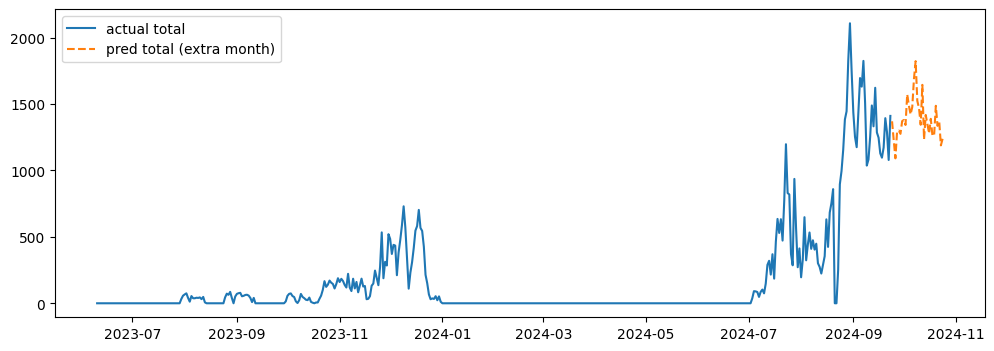

In [11]:
# Total consumption plot

plt.figure(figsize=(12,4))
plt.plot(df.groupby("Date")["kwh"].sum(), label="actual total")
plt.plot(preds_df.groupby("Date")["pred_kwh"].sum(), "--", label="pred total (extra month)")
plt.legend()
plt.show()